In [1]:
import io
import aiohttp
import asyncio
import requests
import numpy as np
from tqdm.auto import tqdm
from glob import glob

import meerkat as mk

from PIL import Image

In [2]:
ngoa = mk.get(
    'ngoa',
    '/data/datasets/opendata/',
)

ngoa_images = ngoa['published_images']
# ngoa_images['image_224'] = ngoa_images['iiifurl'].to_lambda(lambda x: Image.open(io.BytesIO(requests.get(f"{x}/full/224,224/0/default.jpg").content)))

/home/karan/meerkat/meerkat/datapanel.py:436: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return cls.from_pandas(pd.read_csv(filepath, *args, **kwargs))


,uuid (PandasSeriesColumn),iiifurl (PandasSeriesColumn),iiifthumburl (PandasSeriesColumn),viewtype (PandasSeriesColumn),sequence (PandasSeriesColumn),width (PandasSeriesColumn),height (PandasSeriesColumn),maxpixels (PandasSeriesColumn),created (PandasSeriesColumn),modified (PandasSeriesColumn),depictstmsobjectid (PandasSeriesColumn),assistivetext (PandasSeriesColumn),image (ImageColumn)
0,00004dec-8300-4487-8d89-562d0126b6a1,https://api.nga.gov/iiif/00004dec-8300-4487-8d89-562d0126b6a1,"https://api.nga.gov/iiif/00004dec-8300-4487-8d89-562d0126b6a1/full/!200,200/0/default.jpg",primary,0.0,2623,4000,640.0,2010-09-07 15:08:48-04,2022-06-15 12:51:00-04,11975,NaN,
1,00007f61-4922-417b-8f27-893ea328206c,https://api.nga.gov/iiif/00007f61-4922-417b-8f27-893ea328206c,"https://api.nga.gov/iiif/00007f61-4922-417b-8f27-893ea328206c/full/!200,200/0/default.jpg",primary,0.0,3365,4332,NaN,2013-07-05 15:41:08-04,2022-05-23 14:59:28-04,17387,NaN,
2,0000bd8c-39de-4453-b55d-5e28a9beed38,https://api.nga.gov/iiif/0000bd8c-39de-4453-b55d-5e28a9beed38,"https://api.nga.gov/iiif/0000bd8c-39de-4453-b55d-5e28a9beed38/full/!200,200/0/default.jpg",primary,0.0,3500,4688,NaN,2013-08-05 14:31:59-04,2022-05-23 15:05:58-04,19245,NaN,
3,0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,https://api.nga.gov/iiif/0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,"https://api.nga.gov/iiif/0000e5a4-7d32-4c2a-97c6-a6b571c9fd71/full/!200,200/0/default.jpg",primary,0.0,2252,3000,NaN,2013-03-18 14:39:55-04,2022-05-17 18:19:25-04,153987,NaN,
4,0001668a-dd1c-48e8-9267-b6d1697d43c8,https://api.nga.gov/iiif/0001668a-dd1c-48e8-9267-b6d1697d43c8,"https://api.nga.gov/iiif/0001668a-dd1c-48e8-9267-b6d1697d43c8/full/!200,200/0/default.jpg",primary,0.0,3446,4448,NaN,2014-01-02 14:50:50-05,2022-05-23 15:39:38-04,23830,NaN,
5,00018ee2-2b87-444d-afbf-b5d916306d2b,https://api.nga.gov/iiif/00018ee2-2b87-444d-afbf-b5d916306d2b,"https://api.nga.gov/iiif/00018ee2-2b87-444d-afbf-b5d916306d2b/full/!200,200/0/default.jpg",primary,0.0,3194,4000,640.0,2010-09-03 15:37:04-04,2022-06-15 12:49:31-04,43122,NaN,
6,0001ddbf-22c7-4c29-add2-05e8b63fac72,https://api.nga.gov/iiif/0001ddbf-22c7-4c29-add2-05e8b63fac72,"https://api.nga.gov/iiif/0001ddbf-22c7-4c29-add2-05e8b63fac72/full/!200,200/0/default.jpg",primary,0.0,3026,4000,640.0,2012-09-06 10:56:38-04,2022-06-15 13:19:34-04,54733,NaN,
7,0002991a-98fa-42bd-bb33-fd0e2ff1ed1f,https://api.nga.gov/iiif/0002991a-98fa-42bd-bb33-fd0e2ff1ed1f,"https://api.nga.gov/iiif/0002991a-98fa-42bd-bb33-fd0e2ff1ed1f/full/!200,200/0/default.jpg",primary,0.0,2652,4000,640.0,2010-09-07 15:26:11-04,2022-06-15 12:51:07-04,12011,NaN,
8,0003654a-c31d-47c2-924b-17a676d16627,https://api.nga.gov/iiif/0003654a-c31d-47c2-924b-17a676d16627,"https://api.nga.gov/iiif/0003654a-c31d-47c2-924b-17a676d16627/full/!200,200/0/default.jpg",primary,0.0,2621,4000,NaN,2015-10-05 16:36:35-04,2022-06-14 11:28:28-04,203015,NaN,
9,0003d4e4-d7fd-4835-8d27-1e9e20672e39,https://api.nga.gov/iiif/0003d4e4-d7fd-4835-8d27-1e9e20672e39,"https://api.nga.gov/iiif/0003d4e4-d7fd-4835-8d27-1e9e20672e39/full/!200,200/0/default.jpg",primary,0.0,3000,2648,640.0,2014-11-19 14:24:42-05,2022-05-17 18:33:59-04,71457,NaN,

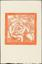
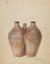
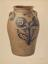
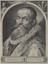
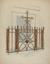
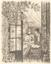
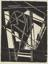
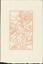
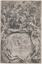
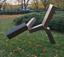
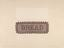
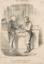
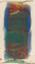
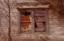
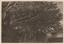
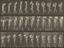
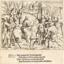
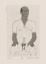
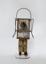

In [4]:
ngoa_images

In [9]:
ngoa_images['image_224_url'] = ngoa_images['iiifurl'].to_lambda(lambda x: f"{x}/full/224,224/0/default.jpg")

,uuid (PandasSeriesColumn),iiifurl (PandasSeriesColumn),iiifthumburl (PandasSeriesColumn),viewtype (PandasSeriesColumn),sequence (PandasSeriesColumn),width (PandasSeriesColumn),height (PandasSeriesColumn),maxpixels (PandasSeriesColumn),created (PandasSeriesColumn),modified (PandasSeriesColumn),depictstmsobjectid (PandasSeriesColumn),assistivetext (PandasSeriesColumn),image (ImageColumn),image_224_url (LambdaColumn)
0,00004dec-8300-4487-8d89-562d0126b6a1,https://api.nga.gov/iiif/00004dec-8300-4487-8d89-562d0126b6a1,"https://api.nga.gov/iiif/00004dec-8300-4487-8d89-562d0126b6a1/full/!200,200/0/default.jpg",primary,0.0,2623,4000,640.0,2010-09-07 15:08:48-04,2022-06-15 12:51:00-04,11975,NaN,,LambdaCell
1,00007f61-4922-417b-8f27-893ea328206c,https://api.nga.gov/iiif/00007f61-4922-417b-8f27-893ea328206c,"https://api.nga.gov/iiif/00007f61-4922-417b-8f27-893ea328206c/full/!200,200/0/default.jpg",primary,0.0,3365,4332,NaN,2013-07-05 15:41:08-04,2022-05-23 14:59:28-04,17387,NaN,,LambdaCell
2,0000bd8c-39de-4453-b55d-5e28a9beed38,https://api.nga.gov/iiif/0000bd8c-39de-4453-b55d-5e28a9beed38,"https://api.nga.gov/iiif/0000bd8c-39de-4453-b55d-5e28a9beed38/full/!200,200/0/default.jpg",primary,0.0,3500,4688,NaN,2013-08-05 14:31:59-04,2022-05-23 15:05:58-04,19245,NaN,,LambdaCell
3,0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,https://api.nga.gov/iiif/0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,"https://api.nga.gov/iiif/0000e5a4-7d32-4c2a-97c6-a6b571c9fd71/full/!200,200/0/default.jpg",primary,0.0,2252,3000,NaN,2013-03-18 14:39:55-04,2022-05-17 18:19:25-04,153987,NaN,,LambdaCell
4,0001668a-dd1c-48e8-9267-b6d1697d43c8,https://api.nga.gov/iiif/0001668a-dd1c-48e8-9267-b6d1697d43c8,"https://api.nga.gov/iiif/0001668a-dd1c-48e8-9267-b6d1697d43c8/full/!200,200/0/default.jpg",primary,0.0,3446,4448,NaN,2014-01-02 14:50:50-05,2022-05-23 15:39:38-04,23830,NaN,,LambdaCell

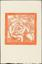
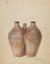
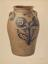
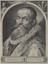
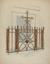

In [10]:
ngoa_images.lz[:5]

In [ ]:
# Downloading images at 224 x 224 resolution and then running them through CLIP

In [112]:
async def get(i, session):
    url = ngoa_images['image_224_url'][i]
    async with session.get(url=url) as response:
        res = await response.read()
        try:
            res = Image.open(io.BytesIO(res))
        except:
            res = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))
        return res
            
async def all_work(indices):
    async with aiohttp.ClientSession() as session:
        return await asyncio.gather(*[get(i, session) for i in indices])



In [113]:
all_outputs = []
for i in tqdm(range(0, len(ngoa_images), 1000)):
    outputs = await all_work(range(i, min(i+1000, len(ngoa_images))))
    all_outputs.extend(outputs)

  0%|          | 0/105 [00:00<?, ?it/s]

In [116]:
ngoa_images['image_224'] = all_outputs

In [117]:
image_224_dp = ngoa_images['uuid', 'image_224']

In [122]:
mk.embed(image_224_dp, 'image_224', modality='image', pbar=True, batch_size=32)

  0%|          | 0/3266 [00:00<?, ?it/s]

,uuid (PandasSeriesColumn),image_224 (ListColumn),clip(image_224) (NumpyArrayColumn)
0,00004dec-8300-4487-8d89-562d0126b6a1,,"np.ndarray(shape=(512,))"
1,00007f61-4922-417b-8f27-893ea328206c,,"np.ndarray(shape=(512,))"
2,0000bd8c-39de-4453-b55d-5e28a9beed38,,"np.ndarray(shape=(512,))"
3,0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,,"np.ndarray(shape=(512,))"
4,0001668a-dd1c-48e8-9267-b6d1697d43c8,,"np.ndarray(shape=(512,))"
...,...,...,...
104500,fffe6d61-e686-478d-bafb-ddae9a48c4de,,"np.ndarray(shape=(512,))"
104501,fffeab03-0f91-49ba-884a-648e6f84598f,,"np.ndarray(shape=(512,))"
104502,ffff2faf-fb5a-479c-b5dc-408245cdc1a0,,"np.ndarray(shape=(512,))"
104503,ffff3431-0d5a-4f85-b7f3-2678093d2418,,"np.ndarray(shape=(512,))"


In [ ]:
image_224_dp['uuid', 'clip(image_224)'].write(path='/data/datasets/opendata/ngoa_published_images_224_clip.mk')

In [133]:
# Save to disk
image_224_dp.map(lambda x: x['image_224'].save(f"/data/datasets/opendata/published_images_224/{x['uuid']}.jpg"), pbar=True, num_workers=8)

  0%|          | 0/104505 [00:00<?, ?it/s]

,(ListColumn)
0,None
1,None
2,None
3,None
4,None
...,...
104500,None
104501,None
104502,None
104503,None


In [3]:
# Load back images and CLIP embeddings
dp = mk.DataPanel({'image_path': glob('/data/datasets/opendata/published_images_224/*')})
dp['uuid'] = dp['image_path'].str.split("/").str.get(-1).str.rstrip(".jpg")
dp['image_224'] = mk.ImageColumn.from_filepaths(dp['image_path'])
dp = dp.merge(mk.DataPanel.read('/data/datasets/opendata/ngoa_published_images_224_clip.mk/'), on='uuid')
dp = dp.sort('uuid')

,uuid (PandasSeriesColumn),image_path (PandasSeriesColumn),image_224 (ImageColumn),clip(image_224) (NumpyArrayColumn)
0,00004dec-8300-4487-8d89-562d0126b6a1,/data/datasets/opendata/published_images_224/00004dec-8300-4487-8d89-562d0126b6a1.jpg,,"np.ndarray(shape=(512,))"
1,00007f61-4922-417b-8f27-893ea328206c,/data/datasets/opendata/published_images_224/00007f61-4922-417b-8f27-893ea328206c.jpg,,"np.ndarray(shape=(512,))"
2,0000bd8c-39de-4453-b55d-5e28a9beed38,/data/datasets/opendata/published_images_224/0000bd8c-39de-4453-b55d-5e28a9beed38.jpg,,"np.ndarray(shape=(512,))"
3,0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,/data/datasets/opendata/published_images_224/0000e5a4-7d32-4c2a-97c6-a6b571c9fd71.jpg,,"np.ndarray(shape=(512,))"
4,0001668a-dd1c-48e8-9267-b6d1697d43c8,/data/datasets/opendata/published_images_224/0001668a-dd1c-48e8-9267-b6d1697d43c8.jpg,,"np.ndarray(shape=(512,))"
...,...,...,...,...
104500,fffe6d61-e686-478d-bafb-ddae9a48c4de,/data/datasets/opendata/published_images_224/fffe6d61-e686-478d-bafb-ddae9a48c4de.jpg,,"np.ndarray(shape=(512,))"
104501,fffeab03-0f91-49ba-884a-648e6f84598f,/data/datasets/opendata/published_images_224/fffeab03-0f91-49ba-884a-648e6f84598f.jpg,,"np.ndarray(shape=(512,))"
104502,ffff2faf-fb5a-479c-b5dc-408245cdc1a0,/data/datasets/opendata/published_images_224/ffff2faf-fb5a-479c-b5dc-408245cdc1a0.jpg,,"np.ndarray(shape=(512,))"
104503,ffff3431-0d5a-4f85-b7f3-2678093d2418,/data/datasets/opendata/published_images_224/ffff3431-0d5a-4f85-b7f3-2678093d2418.jpg,,"np.ndarray(shape=(512,))"

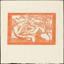
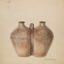
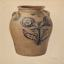
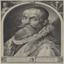
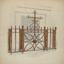
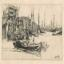
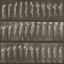
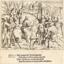
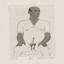
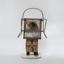

In [4]:
dp